In [1]:
# ImageDataGenerator를 이용해서 Cats and Dogs binary classification
# 문제를 해결해 보아요!

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam  # 평균적으로 높은 효율을 내는 알고리즘
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# ImageDataGenerator 객체 생성
Train_Datagen =  ImageDataGenerator(rescale=1/255)
Test_Datagen =  ImageDataGenerator(rescale=1/255)

In [3]:
train_dir = './cats_and_dogs/train'
test_dir = './cats_and_dogs/test'

In [4]:
# ImageDataGenerator  설정

train_generator = Train_Datagen.flow_from_directory(
    train_dir,   # 학습용 이미지를 가져올 폴더
    classes=['cats', 'dogs'],  # cats 포더의 이미지 label을 0으로
                               #dogs 폴의 이미지는 label을 1로 설정
    target_size=(150, 150),    #이미지 resize
    batch_size=20,             #한번에 20개의 이미지만 가져와서 학습
    class_mode='binary'        #이진분류인 경우 설정
)

test_generator = Test_Datagen.flow_from_directory(
    test_dir,   # 학습용 이미지를 가져올 폴더
    classes=['cats', 'dogs'],  # cats 포더의 이미지 label을 0으로
                               #dogs 폴의 이미지는 label을 1로 설정
    target_size=(150, 150),    #이미지 resize
    batch_size=20,             #한번에 20개의 이미지만 가져와서 학습
    class_mode='binary'        #이진분류인 경우 설정
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
## 전이학습에 대해서 알아보아요!!
## 사용하는 기학습된 네트워크(Pretrained Network)는
## VGG16을 이용해 보아요!

from tensorflow.keras.applications import VGG16

model_base = VGG16(weights='imagenet',
                   include_top=False,    # classification 제외!
                   input_shape=(150,150,3))

print(model_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [6]:
# CNN Model 구현
model = Sequential()

model.add(model_base)

model.add(Flatten())    # 전체 데이터를 4차원에서 2차원으로 변경

model.add(Dense(256, activation= 'relu'))

# output layer
model.add(Dense(units=1,
                activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


모델을 컴파일하고 훈련하기전에 합성곱 기반 층을 freezing 하는것이 중요한데

Layer를 Freezing 하는것은 training하는동안 layer의 weight가 업데이트 되는것을 막는것이다.

이를 통해서 Convolutional base에 의해서 train되었던 것들이 수정될것이다.

케라스에서는 trainable 속성을 False로 설정해서 네트워크를 Freeze할수 있다.

In [7]:
print('before freeze, len of trainable_weights', len(model.trainable_weights))
model_base.trainable = False
print('after  freeze, len of trainable_weights', len(model.trainable_weights))

before freeze, len of trainable_weights 30
after  freeze, len of trainable_weights 4


앞에서 보면 training 되는 parameter가 엄청 많은데

weight가 30개 밖에 안된다는것이 이해가 안될 수 있다.

하지만 결국 층마다 2개씩( weight matrix, bias vector)가 추가된다고 생각하면 된다.

y = wx + b 에서 w가 weight matrix, b가 bias vector라서

각 layer마다 2개씩이라고 생각하면 된다.

In [8]:
#for layer in model_base.layers[:-10]:
#   layer.trainable = False

for layer in model_base.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000025B4213ECA0> False
<keras.layers.convolutional.Conv2D object at 0x0000025B4221D370> False
<keras.layers.convolutional.Conv2D object at 0x0000025B4221D970> False
<keras.layers.pooling.MaxPooling2D object at 0x0000025B423D1D00> False
<keras.layers.convolutional.Conv2D object at 0x0000025B423D1310> False
<keras.layers.convolutional.Conv2D object at 0x0000025B423E9CA0> False
<keras.layers.pooling.MaxPooling2D object at 0x0000025B423ED730> False
<keras.layers.convolutional.Conv2D object at 0x0000025B423ED3D0> False
<keras.layers.convolutional.Conv2D object at 0x0000025B4251E2E0> False
<keras.layers.convolutional.Conv2D object at 0x0000025B4251E430> False
<keras.layers.pooling.MaxPooling2D object at 0x0000025B423D8AC0> False
<keras.layers.convolutional.Conv2D object at 0x0000025B4251EF70> False
<keras.layers.convolutional.Conv2D object at 0x0000025B42535EE0> False
<keras.layers.convolutional.Conv2D object at 0x0000025B42530250> False
<ker

In [9]:
# print(model.summary())
# model이 어떻게 동작하는지를 지정
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
print(model_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [12]:
# 설정이 다 되었으면 모델을 학습.
history = model.fit(train_generator,
          steps_per_epoch=100,
          epochs=30,
          verbose=1,
          validation_data=test_generator,
          validation_steps=50)

Epoch 1/30
100/100 [==============================] - 21s 157ms/step - loss: 0.3829 - accuracy: 0.8140 - val_loss: 0.2892 - val_accuracy: 0.8780
Epoch 2/30
100/100 [==============================] - 16s 156ms/step - loss: 0.2267 - accuracy: 0.9120 - val_loss: 0.2567 - val_accuracy: 0.8820
Epoch 3/30
100/100 [==============================] - 16s 156ms/step - loss: 0.1684 - accuracy: 0.9380 - val_loss: 0.3193 - val_accuracy: 0.8480
Epoch 4/30
100/100 [==============================] - 16s 157ms/step - loss: 0.1313 - accuracy: 0.9590 - val_loss: 0.2506 - val_accuracy: 0.8920
Epoch 5/30
100/100 [==============================] - 16s 158ms/step - loss: 0.0995 - accuracy: 0.9725 - val_loss: 0.2484 - val_accuracy: 0.8860
Epoch 6/30
100/100 [==============================] - 16s 158ms/step - loss: 0.0762 - accuracy: 0.9820 - val_loss: 0.2545 - val_accuracy: 0.8840
Epoch 7/30
100/100 [==============================] - 16s 158ms/step - loss: 0.0634 - accuracy: 0.9900 - val_loss: 0.2582 - val_ac

In [13]:
import matplotlib.pylab as plt

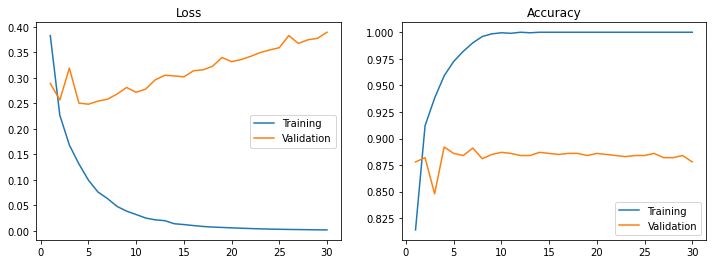

In [14]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 30)